In [1]:
import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from openpyxl import load_workbook

In [2]:
!gdown --id 163MC5wZ2ohH3a95GrOz1m03CLTHUK8Vh
#https://drive.google.com/file/d/163MC5wZ2ohH3a95GrOz1m03CLTHUK8Vh/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=163MC5wZ2ohH3a95GrOz1m03CLTHUK8Vh
To: /content/PREPARATIVO POWER BI.xlsx
100% 618k/618k [00:00<00:00, 3.76MB/s]


In [3]:
df=pd.read_excel('PREPARATIVO POWER BI.xlsx')
df=df.fillna(value=0)
cols=['Cód. trabajador','Nombre trabajador','Categoría','Tipo contrato','DEPARTAMENTO','temporalidad','Itx','Antigüedad','Sexo']
dfnum=df.drop(columns=cols)
numcols=dfnum.columns
df[numcols]=df[numcols].apply(pd.to_numeric)

In [4]:
#ESPECIFICAMOS EL NOMBRE DEL ARCHIVO DONDE GUARDAMOS LOS DATOS
archivo_nombre='estruc.xlsx'

In [5]:
#si le indicas dni te elimina las columnas y los complementos que son 0. Si no lo indicas te aparecerá la categoría entera pero sólo las columnas que tengan todo 0 se eliminarán
def complementos_find(categoria, dni):
  df_comp=pd.pivot_table(df, index=['Categoría', 'Cód. trabajador'])
  df_comp=df_comp.loc[categoria]
  df_comp=df_comp.drop(columns=['Diferencia.1','Horas semanales','SALARIO BASE','CALCULADO','Ant. Años','Diferencia','Tot. Devengado','Total salario complementos','Total salario convenio ','Complementos convenio','Complementos no convenio'])
  df_comp=df_comp.loc[:, (df_comp != 0).any(axis=0)]
  

  if dni!='':
    df_comp=df_comp.loc[dni].to_frame('Complementos')
  
    for i in df_comp['Complementos']:
      if i==0:
        df_comp=df_comp.loc[(df_comp!=0).any(axis=1)]
  
  return df_comp

complementos_find('ANALISTA','')

,A CUENTA TRAMO,COMP.CARGO JEFE SECCION,COMPLEMENTO PERSONAL,PAGA EXTRA BENEFICIOS,TRAMO I,TRAMO III,TRAMO IV,TRAMO V,TRAMO VII
Cód. trabajador,,,,,,,,,
23007855N,0.00,0.00,71.65,142.99,205.53,0.00,0.00,0.00,0.00
25587007J,1365.83,0.00,121.10,147.11,0.00,0.00,616.58,0.00,0.00
27483301A,0.00,0.00,0.00,137.02,205.53,0.00,0.00,0.00,0.00
34787542L,600.00,0.00,121.10,147.11,0.00,0.00,616.58,0.00,0.00
34796454F,0.00,0.00,0.00,137.02,0.00,0.00,0.00,822.11,0.00
34811755J,0.00,331.78,86.14,171.84,0.00,411.06,0.00,0.00,0.00
34826773N,0.00,0.00,95.53,144.98,205.53,0.00,0.00,0.00,0.00
34835993D,0.00,0.00,0.00,137.02,205.53,0.00,0.00,0.00,0.00
48477859T,0.00,0.00,47.77,141.00,205.53,0.00,0.00,0.00,0.00


In [ ]:
#agrupación del total devengado por intervalos entre Hombres y Mujeres
df_sex=df.set_index('Sexo')
df_men=df_sex.loc['Hombre']
df_women=df_sex.loc['Mujer']

dfmen_intervals=df_men.groupby(pd.cut(df_men['Tot. Devengado'],[0,1200,2400,3600,4800,6000])).count()
dfmen_intervals=dfmen_intervals['Tot. Devengado']
dfmen_intervals=dfmen_intervals.to_frame('Hombres, Tot. Devengado')
dfmen_intervals['fi%']=[round(i/dfmen_intervals.sum(),2) for i in dfmen_intervals['Hombres, Tot. Devengado'] ]
dfmen_intervals['fi%']=dfmen_intervals['fi%'].astype('float')

dfwomen_intervals=df_women.groupby(pd.cut(df_women['Tot. Devengado'],[0,1200,2400,3600,4800,6000])).count()
dfwomen_intervals=dfwomen_intervals['Tot. Devengado']
dfwomen_intervals=dfwomen_intervals.to_frame('Mujeres, Tot. Devengado')
dfwomen_intervals['fi%']=[round(i/dfwomen_intervals.sum(),2) for i in dfwomen_intervals['Mujeres, Tot. Devengado'] ]
dfwomen_intervals['fi%']=dfwomen_intervals['fi%'].astype('float')

df_intervals=pd.merge(dfmen_intervals,dfwomen_intervals,on=dfmen_intervals.index)
df_intervals.rename(columns={'key_0':'Intervalos','fi%_x':'%Hombres','fi%_y':'%Mujeres'})

writer= pd.ExcelWriter(archivo_nombre, engine='openpyxl')
df_intervals.to_excel(writer, sheet_name='Intervalos', index=False)
writer.save()
writer.close()

In [ ]:
#LISTADO EN EXCEL
def generar_diferencias_complementosNoConvenio(df):
#tabla para hombres

  df_men_bycat_compl_convenio=pd.pivot_table(df, index='Categoría', aggfunc='mean')[['Total salario convenio ','Complementos convenio', 'Complementos no convenio']]
  df_men_bycat_compl_convenio=df_men_bycat_compl_convenio.reset_index()
#juntamos los promedios por categoría

  df_men1=df.merge(df_men_bycat_compl_convenio, on='Categoría')
  df_men1=df_men1.rename(columns={'Total salario convenio _x':'Total salario convenio','Complementos convenio_x':'Complementos convenio','Complementos no convenio_x':'Complementos no convenio','Total salario convenio _y':'salario convenio media categoría','Complementos convenio_y':'Complementos convenio media categoría','Complementos no convenio_y':'Complementos no convenio media categoría'})
  df_men1=df_men1[['Cód. trabajador','Nombre trabajador','Categoría','DEPARTAMENTO','Ant. Años','Tot. Devengado','Total salario complementos','Total salario convenio','Complementos convenio','Complementos no convenio', 'Complementos convenio media categoría','Complementos no convenio media categoría']]
#cálculo de la diferencia entre salario convenio y el promedio (por CATEGORIA) de complementos no convenio 

  df_men1['Diferencia_SC_CNCProm']=df_men1['Complementos no convenio']-df_men1['Complementos no convenio media categoría']
#le ponemos el filtro para saber quién tiene diferencias positivas. Si no filtramos nos saldrán aquellos que no tengan complementos no covenio. Comparar la brecha de los complementos no convenio con aquellos que no tienen complementos no convenio no tiene sentido.
  filtrados_men=df_men1[df_men1['Complementos no convenio']>df_men1['Complementos no convenio media categoría']] 
  #filtrados_men=df_men1 #sin filtrar
  with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer1:
    writer1.book = load_workbook(archivo_nombre)
    filtrados_men.to_excel(writer1, sheet_name="Diferencias comp. no convenio", index=False)
    writer1.save()
  filtrados_men.to_excel('df.xlsx',engine='openpyxl')
  return filtrados_men.head()
generar_diferencias_complementosNoConvenio(df)

/usr/local/lib/python3.7/dist-packages/openpyxl/workbook/child.py:102: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Cód. trabajador,Nombre trabajador,Categoría,DEPARTAMENTO,Ant. Años,Tot. Devengado,Total salario complementos,Total salario convenio,Complementos convenio,Complementos no convenio,Complementos convenio media categoría,Complementos no convenio media categoría,Diferencia_SC_CNCProm
0,34796454F,GARCÍA ARAGONÉS JUAN ANTONIO,ANALISTA,DEPARTAMENTO INGENIERÍA DE SISTEMAS,6.238356,2603.34,2466.32,1781.23,137.02,822.11,279.312308,546.777692,275.332308
4,25587007J,LEÓN MORALES SERGIO,ANALISTA,DEPARTAMENTO INGENIERÍA DE SISTEMAS,22.402740,3894.83,3626.62,1912.42,268.21,1982.41,279.312308,546.777692,1435.632308
5,34787542L,MARTÍNEZ AGUILAR LUIS,ANALISTA,DEPARTAMENTO ÁREA TÉCNICA,22.153425,3129.00,2860.79,1912.42,268.21,1216.58,279.312308,546.777692,669.802308
6,77513988D,ESPIÑEIRA CARRILLO LUIS,ANALISTA,DEPARTAMENTO ING SOFTWARE Y CAMPUS VIRTUAL,22.145205,3505.02,2877.37,2271.86,627.65,1233.16,279.312308,546.777692,686.382308
31,53116707R,CAL FIGUEROA DAVID,AUXILIAR ADMINISTRATIVO,SERVICIO DE DEPORTES,5.191781,3200.45,3114.28,1120.15,86.17,2080.30,86.170000,76.560533,2003.739467


In [ ]:
#COMPLEMENTOS CONVENIO. TOTAL
df2=df.set_index('Sexo')
df_h=df2.loc['Hombre']
df_m=df2.loc['Mujer']

df_describe=df_h['Complementos convenio'].describe().to_frame('HOMBRES')
df_describe['MUJERES']=round(df_m['Complementos convenio'].describe().to_frame('MUJERES'),2)

with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer2:
  writer2.book = load_workbook(archivo_nombre)
  df_describe.to_excel(writer2, sheet_name="Comp convenio Total")
  writer2.save()


#df_describe.to_excel(writer, engine='openpyxl', sheet_name='Total')

In [ ]:
#COMPLEMENTOS NO CONVENIO. TOTAL
df2=df.set_index('Sexo')
df_h=df2.loc['Hombre']
df_m=df2.loc['Mujer']

df_describe=df_h['Complementos no convenio'].describe().to_frame('HOMBRES')
df_describe['MUJERES']=round(df_m['Complementos no convenio'].describe().to_frame('MUJERES'),2)

with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer3:
  writer3.book = load_workbook(archivo_nombre)
  df_describe.to_excel(writer3, sheet_name="Comp. no Convenio Total")
  writer3.save()

df_describe

,HOMBRES,MUJERES
count,224.000000,144.00
mean,364.476040,152.75
std,512.452029,289.56
min,0.000000,0.00
25%,0.000000,0.00
50%,167.190000,0.00
75%,479.045000,246.80
max,2153.650000,2361.30


In [ ]:
#COMPLEMENTOS NO CONVENIO. MEDIAS POR CATEGORÍA. HOMBRES Y MUJERES
mean_bycat=round(pd.pivot_table(df_h,index=['Categoría'], aggfunc='mean')['Complementos no convenio'].to_frame('Hombres Media'),2)

mean_bycat['Mujeres Media']=round(pd.pivot_table(df_m,index=['Categoría'], aggfunc='mean')['Complementos no convenio'].to_frame('Mujeres Media'),2)
mean_bycat['Dif %']= round((mean_bycat['Hombres Media']/mean_bycat['Mujeres Media'])*100,2)

with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer4:
  writer4.book = load_workbook(archivo_nombre)
  mean_bycat.to_excel(writer4, sheet_name="Comp. no Convenio Medias")
  writer4.save()

mean_bycat

,Hombres Media,Mujeres Media,Dif %
Categoría,,,
ANALISTA,558.09,411.06,135.77
AUXILIAR 2ª DE SERVICIOS,0.00,0.00,NaN
AUXILIAR ADMINISTRATIVO,155.73,20.78,749.42
AUXILIAR BIBLIOTECA,110.42,NaN,NaN
AYUDANTE DE BIBLIOTECA,102.64,225.64,45.49
AYUDANTE OFICIAL LABORATORIOS,205.09,0.00,inf
BEDEL,72.11,NaN,NaN
BEDEL CARGO CONSERJE,535.36,NaN,NaN
GUARDA,133.97,37.65,355.83


In [ ]:
#DIFERENCIA ENTRE: COMPLEMENTOS NO CONVENIO - MEDIA (DE LA CATEGORIA) COMPLEMENTOS NO CONVENIO
#cuando no filtramos y dejamos a aquellos trabajadores que no tienen complementos no convenio, las medias nos salen 0. 
filtrados=pd.read_excel('df.xlsx')
filtrados1=round(pd.pivot_table(filtrados, index=['Categoría'],aggfunc='mean')['Diferencia_SC_CNCProm'].to_frame('Brecha complementos no convenio, Promedio'),1)
#filtrados1['Diferencia std']=round(pd.pivot_table(filtrados, index=['Categoría'],aggfunc='std')['Diferencia_SC_CNCProm'].to_frame('Diferencia std'),2)

with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer5:
  writer5.book = load_workbook(archivo_nombre)
  filtrados1.to_excel(writer5, sheet_name="Comp. no Convenio Media Diferencias")
  writer5.save()

filtrados1

/usr/local/lib/python3.7/dist-packages/openpyxl/workbook/child.py:102: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,"Brecha complementos no convenio, Promedio"
Categoría,
ANALISTA,766.8
AUXILIAR ADMINISTRATIVO,441.7
AYUDANTE DE BIBLIOTECA,143.6
AYUDANTE OFICIAL LABORATORIOS,102.5
BEDEL,205.4
GUARDA,82.7
JEFE SUPERIOR,549.3
OFICIAL 1 ADMINISTRATIVO,419.0
OFICIAL 1 LABORATORIOS/OFICIOS,236.0


In [ ]:
filtrados.head()

,Unnamed: 0,Cód. trabajador,Nombre trabajador,Categoría,DEPARTAMENTO,Ant. Años,Tot. Devengado,Total salario complementos,Total salario convenio,Complementos convenio,Complementos no convenio,Complementos convenio media categoría,Complementos no convenio media categoría,Diferencia_SC_CNCProm
0,0,34796454F,GARCÍA ARAGONÉS JUAN ANTONIO,ANALISTA,DEPARTAMENTO INGENIERÍA DE SISTEMAS,6.238356,2603.34,2466.32,1781.23,137.02,822.11,279.312308,546.777692,275.332308
1,4,25587007J,LEÓN MORALES SERGIO,ANALISTA,DEPARTAMENTO INGENIERÍA DE SISTEMAS,22.402740,3894.83,3626.62,1912.42,268.21,1982.41,279.312308,546.777692,1435.632308
2,5,34787542L,MARTÍNEZ AGUILAR LUIS,ANALISTA,DEPARTAMENTO ÁREA TÉCNICA,22.153425,3129.00,2860.79,1912.42,268.21,1216.58,279.312308,546.777692,669.802308
3,6,77513988D,ESPIÑEIRA CARRILLO LUIS,ANALISTA,DEPARTAMENTO ING SOFTWARE Y CAMPUS VIRTUAL,22.145205,3505.02,2877.37,2271.86,627.65,1233.16,279.312308,546.777692,686.382308
4,31,53116707R,CAL FIGUEROA DAVID,AUXILIAR ADMINISTRATIVO,SERVICIO DE DEPORTES,5.191781,3200.45,3114.28,1120.15,86.17,2080.30,86.170000,76.560533,2003.739467


In [ ]:
#COMPLEMENTOS NO CONVENIO. DESVIACIONES POR CATEGORÍA. HOMBRES Y MUJERES
std_bycat=round(pd.pivot_table(df_h,index=['Categoría'], aggfunc='std')['Complementos no convenio'].to_frame('Hombres Std'),2)
std_bycat['Mujeres std']=round(pd.pivot_table(df_m,index=['Categoría'], aggfunc='std')['Complementos no convenio'].to_frame('Mujeres Std'),2)

with pd.ExcelWriter(archivo_nombre, engine='openpyxl') as writer6:
  writer6.book = load_workbook(archivo_nombre)
  std_bycat.to_excel(writer6, sheet_name="Comp. no Convenio Desviaciones")
  writer6.save()

std_bycat

/usr/local/lib/python3.7/dist-packages/openpyxl/workbook/child.py:102: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Hombres Std,Mujeres std
Categoría,,
ANALISTA,615.32,NaN
AUXILIAR 2ª DE SERVICIOS,0.00,0.00
AUXILIAR ADMINISTRATIVO,427.51,77.76
AYUDANTE DE BIBLIOTECA,205.27,62.79
BEDEL,150.12,NaN
GUARDA,67.28,53.25
JEFE SUPERIOR,801.67,NaN
OFICIAL 1 ADMINISTRATIVO,434.37,257.27
OFICIAL 1 LABORATORIOS/OFICIOS,213.25,NaN


In [ ]:
df_pesos=df.set_index('Sexo')
df_pesos=df_pesos[['Complementos convenio', 'Complementos no convenio', 'SALARIO BASE', 'Tot. Devengado']]
#filtramos por aquellas personas que tienen complementos de no convenio. Dejamos fuera a aquellas que no tienen estos complementos.
df_pesosconv=df_pesos[df_pesos['Complementos no convenio']!=0]
df_pesos['% Complementos no convenio/Tot. Devengado']=(df_pesos['Complementos no convenio']/df_pesos['Tot. Devengado'])*100
df_pesos['% Complementos convenio/Tot. Devengado']=(df_pesos['Complementos convenio']/df_pesos['Tot. Devengado'])*100
comp_noconvenio_pesos_h=df_pesos[df_pesos['Complementos no convenio']!=0].loc['Hombre']['% Complementos no convenio/Tot. Devengado'].mean(axis=0) 
comp_convenio_pesos_h=df_pesos.loc['Hombre']['% Complementos convenio/Tot. Devengado'].mean(axis=0)
comp_noconvenio_pesos_m=df_pesos[df_pesos['Complementos no convenio']!=0].loc['Mujer']['% Complementos no convenio/Tot. Devengado'].mean(axis=0) 
comp_convenio_pesos_m=df_pesos.loc['Mujer']['% Complementos convenio/Tot. Devengado'].mean(axis=0)

print('Media de complementos no convenio €, HOMBRES', round(df_pesos.loc['Hombre']['Complementos no convenio'].mean(),2))
print('Media de complementos no convenio €, MUJERES', round(df_pesos.loc['Mujer']['Complementos no convenio'].mean(),2), '\n')
print('Media de complementos convenio €, HOMBRES', round(df_pesos.loc['Hombre']['Complementos convenio'].mean(),2))
print('Media de complementos convenio €, MUJERES', round(df_pesos.loc['Mujer']['Complementos convenio'].mean(),2))
print('-------------------------------------------------------------------------')
print('Media de la contribución de los complementos de no convenio sobre el total devengado, HOMBRES:', comp_noconvenio_pesos_h, "%")
print('Media de la contribución de los complementos de no convenio sobre el total devengado, MUJERES:', comp_noconvenio_pesos_m, "%")
print('-------------------------------------------------------------------------')
print('Media de la contribución de los complementos de convenio sobre el total devengado, HOMBRES:', comp_convenio_pesos_h, "%")
print('Media de la contribución de los complementos de convenio sobre el total devengado, MUJERES:', comp_convenio_pesos_m, "%")

Media de complementos no convenio €, HOMBRES 364.48
Media de complementos no convenio €, MUJERES 152.75 

Media de complementos convenio €, HOMBRES 217.96
Media de complementos convenio €, MUJERES 184.22
-------------------------------------------------------------------------
Media de la contribución de los complementos de no convenio sobre el total devengado, HOMBRES: 22.94487028071408 %
Media de la contribución de los complementos de no convenio sobre el total devengado, MUJERES: 17.1203449939433 %
-------------------------------------------------------------------------
Media de la contribución de los complementos de convenio sobre el total devengado, HOMBRES: 11.81755528118268 %
Media de la contribución de los complementos de convenio sobre el total devengado, MUJERES: 11.80257780980282 %


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------------------
#GRAFICOS

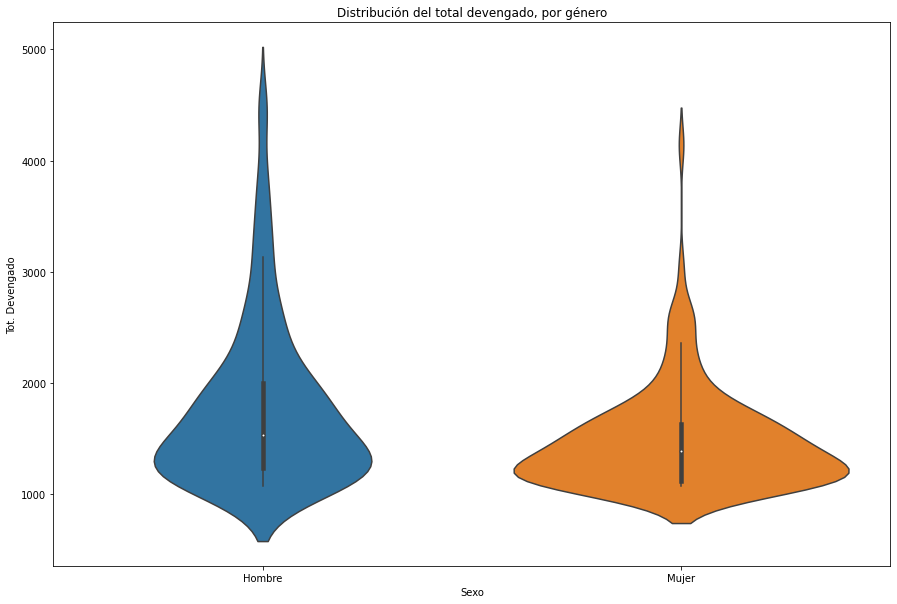

In [ ]:
#se puede ver mayores valores extremos en hombres, mientras que en mujeres hay menos valores extremos pero los sueldos se concentran más en los estratos bajos.
plt.figure(figsize=(15,10))
plt.title('Distribución del total devengado, por género')
sns.violinplot(x='Sexo', y='Tot. Devengado', data=df,orient='v')
#plt.savefig('Violinplot.png')

In [ ]:
#variabilidad del total devengado, sin agrupar por categorías
plt.figure(figsize=(15,10))
fig=px.box(df, x='Sexo', y='Tot. Devengado',points='all',hover_data=['Cód. trabajador'],title='Total devengado por género, totales')
fig.show()
#plt.savefig('boxplot.png')

<Figure size 1080x720 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Años antigüedad, Hombres')

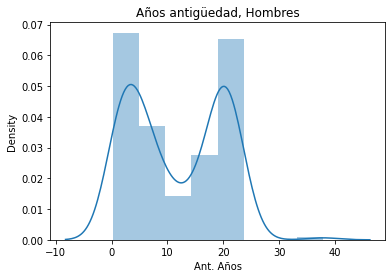

In [ ]:
sns.distplot(df_men['Ant. Años'])
plt.title('Años antigüedad, Hombres')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Años antigüedad, Mujeres')

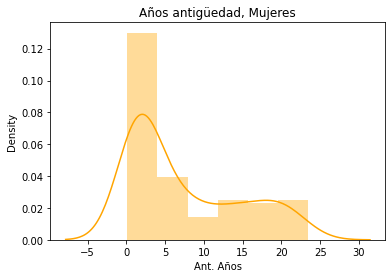

In [ ]:
sns.distplot(df_women['Ant. Años'], color='orange')
plt.title('Años antigüedad, Mujeres')

In [ ]:
plt.figure(figsize=(15,10))
fig=px.box(df_women, x='Categoría', y='Tot. Devengado',title='Mujeres total devengado, por categorías')
fig.show()
#plt.savefig('boxplot_m.png')


<Figure size 1080x720 with 0 Axes>

In [ ]:
fig=px.box(df_men, x='Categoría', y='Tot. Devengado',title='Hombres total devengado, por categorías')
fig.show()
#plt.savefig('boxplot_h.png')

In [ ]:
df_men.groupby(by=['DEPARTAMENTO', 'Cód. trabajador']).sum()

Horas semanales  ...  TRAMO VII
DEPARTAMENTO                              Cód. trabajador                   ...           
ADMINISTRACION                            27471420J                   37.5  ...        0.0
                                          34784555E                   37.5  ...        0.0
                                          48541470Q                   37.5  ...        0.0
                                          48703181Z                   37.5  ...        0.0
                                          52787360Z                   37.5  ...        0.0
...                                                                    ...  ...        ...
UCAM SPANISH SPORTS UNIVERSITY            48635688A                   37.5  ...        0.0
UNIDAD DE DISEÑO DE CONTENIDOS EDUCATIVOS 77854495R                   37.5  ...        0.0
VICERRECTORADO DE INVESTIGACIÓN           27471440X                   37.5  ...        0.0
                                          34818396F                   37.5  ...        0.0
                                          48479627C                   37.5  ...        0.0

[224 rows x 66 columns]

In [ ]:
#Representación del total devengado por categorías y sexo. % del total por género
fig = make_subplots(rows=1, cols=2)
fig = px.pie(df_men, values='Tot. Devengado' ,names='Categoría',title='Hombres Total devengado por categoría')
fig2 = px.pie(df_women, values='Tot. Devengado' ,names='Categoría',title='Mujeres Total devengado por categoría')
fig.show()
fig2.show()
#plt.savefig('pieplots.png')

Text(0.5, 1.0, 'Total devengado por categorías y sexo. PROMEDIO')

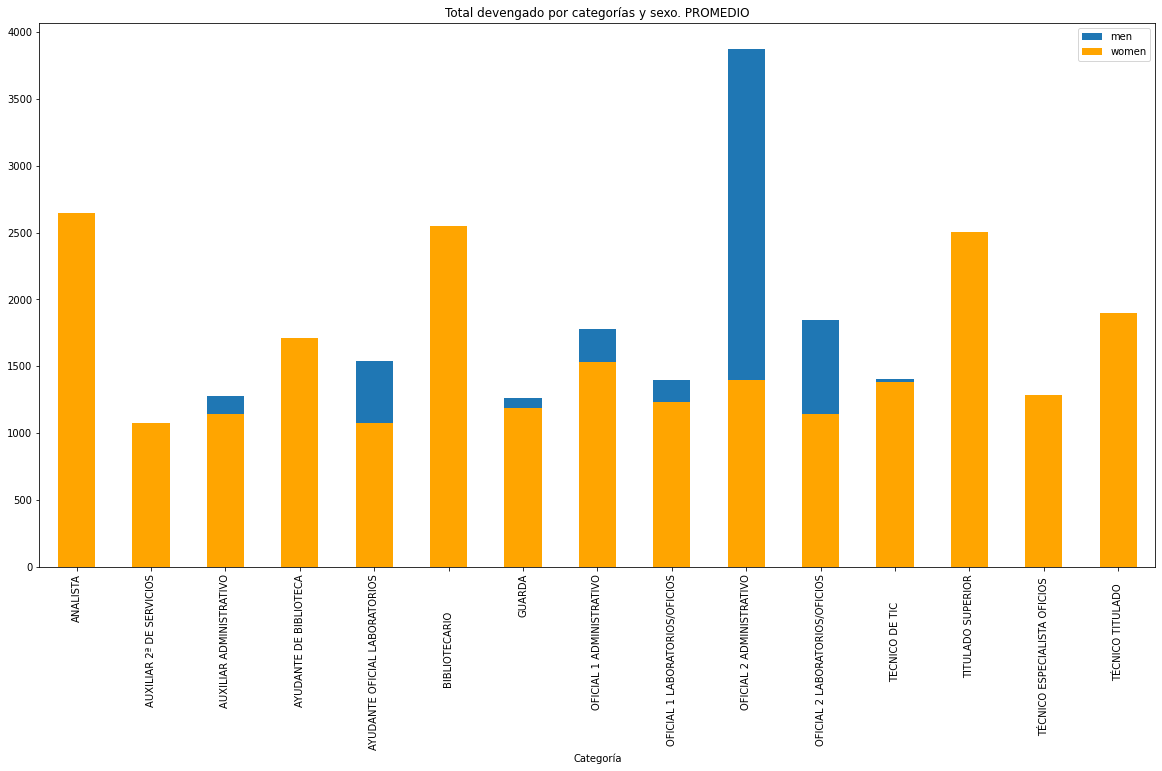

In [ ]:
#por categorías, comparación de media Total Devengado entre homvre y mujer
by_cat_sex=df.groupby(by=['Sexo','Categoría']).mean()
by_cat=df.groupby(by=['Categoría','Sexo']).mean()
by_cat_men=by_cat_sex['Tot. Devengado'].loc['Hombre']
by_cat_women=by_cat_sex['Tot. Devengado'].loc['Mujer']

plt.figure(figsize=(20,10))
by_cat_men.plot(kind='bar',label='men')
by_cat_women.plot(kind='bar',color='orange',label='women')
plt.legend()
plt.title('Total devengado por categorías y sexo. PROMEDIO')
#plt.savefig('mean_bycat.png')

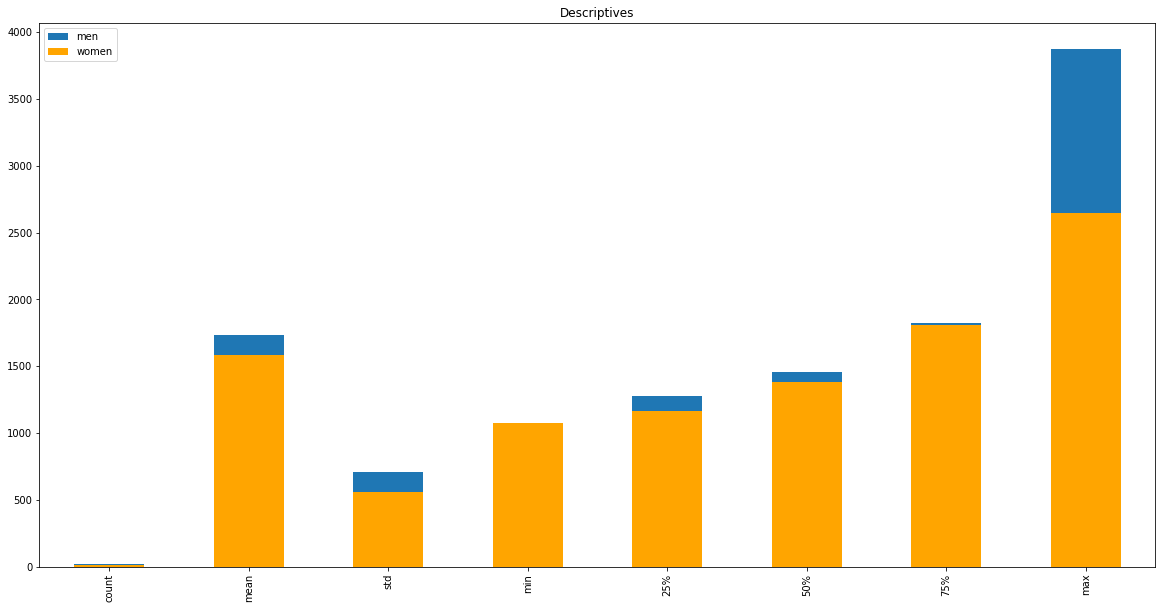

In [ ]:
#por categorías, comparación principales estadísticos entre hombre y mujer
by_catmen=by_cat['Tot. Devengado'].iloc[by_cat.index.get_level_values('Sexo') == 'Hombre']
by_catwomen=by_cat['Tot. Devengado'].iloc[by_cat.index.get_level_values('Sexo') == 'Mujer']
by_catwomen_describe=by_catwomen.describe(include='all')
by_catmen_describe=by_catmen.describe(include='all')

plt.figure(figsize=(20,10))
by_catmen_describe.plot(kind='bar',label='men')
by_catwomen_describe.plot(kind='bar',color='orange',label='women')
plt.title('Descriptives')
plt.legend()
#plt.savefig('statistics.png')

In [ ]:
descriptive=by_catmen_describe.to_frame('Hombres')
descriptive['Mujeres']=by_catwomen_describe
descriptive

,Hombres,Mujeres
count,19.000000,15.000000
mean,1733.279457,1584.030480
std,710.000606,559.335911
min,1074.260000,1074.260000
25%,1277.614194,1163.307500
50%,1459.114667,1383.690000
75%,1822.888729,1804.606329
max,3875.825714,2645.030000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error

#df_women or df_men
def regresion(df):
  X = df['Ant. Años']
  y= df['Tot. Devengado']

  X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=100)
  X_train = X_train[:,np.newaxis]
  X_test = X_test[:,np.newaxis]

  lr = LinearRegression()
  lr.fit(X_train,y_train)
  y_pred = lr.predict(X_test)

  plt.figure(figsize=(12,6))
  plt.scatter(y_test,y_pred,color='r',linestyle='-')
  plt.show()

  mse = mean_squared_error(y_test,y_pred)
  rsq = r2_score(y_test,y_pred)
  print('mean squared error :',mse)
  print('r square :',rsq)
  print('Intercept of the model:',np.array(lr.intercept_))
  print('Coefficient of the line:',np.array(lr.coef_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



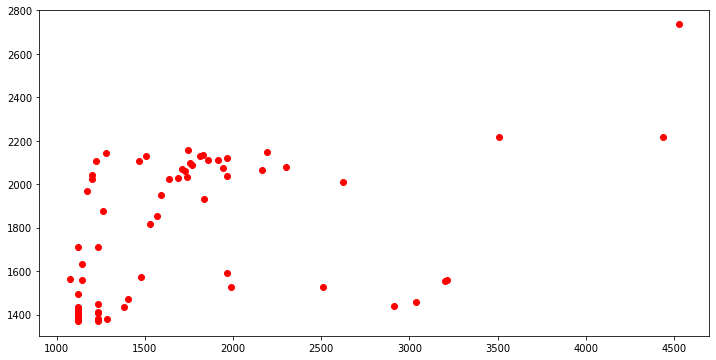

mean squared error : 447987.9155886452
r square : 0.2017391129805759
Intercept of the model: 1364.6783774317487
Coefficient of the line: [36.25798959]


In [ ]:
regresion(df_men)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



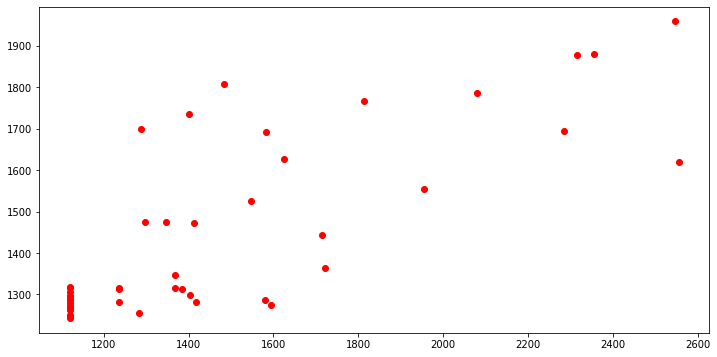

mean squared error : 79574.10564504753
r square : 0.5304436846166599
Intercept of the model: 1236.3881291912912
Coefficient of the line: [31.28452838]


In [ ]:
#las mujeres tienen salario más correlacionado con sus años de antigüedad. La antigüedad explica más el salario que para los hombres. En hombres parece que existen otros factores más determinantes.
regresion(df_women)